# Testing Notebook: Averaging model performance across Baum-Welch iterations over many simulated reps

---
## Purpose of Notebook
(Predone) Locally download a few sample rep ids and construct two tables for each of them measuring the True Positive Rate and False Positive Rate across iterations of Baum-Welch, facilitating averaging.

In [1]:
# Import packages.
import sys
import numpy as np
import gzip
import matplotlib.pyplot as plt

# Print versions of our libraries.
print('numpy', np.__version__)
print('gzip', np.__version__)
print('matplotlib', np.__version__)

numpy 1.22.3
gzip 1.22.3
matplotlib 1.22.3


---
## Function Descriptions

---
### `calc_rep_performance()`
#### Purpose:
`calc_rep_performance()` adds a rep to a dictionary of performances. The key is the rep number and the value is a tuple containing two 1-D numpy arrays (100 long) containing the FPR and TPR from each iteration of Baum-Welch corresponding to the index.
#### Input:
- `rep_num`: int of the rep number (out of 1000, typically)
- `Rep_performances`: Dictionary containing existing rep performances
- `threshold`: the level of confidence of introgression given by the model that will be counted as a guess. Set to .9 as default
#### Output:
- `R_p`: Dictionary containing updated rep performances

In [2]:
def calc_rep_performance(rep_num, Rep_performances, threshold=.9):
    
    # find the filepath for the rep number
    rep_filepath = '/Users/briankirz/Documents/GitHub/mentee_research/kirz/site_pattern_hmm/results_testing/local_test_reps/prufer_results_rep_id_{0}.csv.gz'.format(rep_num+1)
    # OSCAR filepath
    # rep_filepath = './hmm_results/prufer_results_rep_id_{0}_0011_1100.csv.gz'.format(rep_num+1)
    
    # download the array from the rep_results filepath
    rep = np.genfromtxt(rep_filepath, delimiter='\t')

    # max number of BW iterations, should be 100
    max_iter = len(rep[0])-4
    fpr_array = np.zeros(max_iter)
    tpr_array = np.zeros(max_iter)
    
    # Starting in the fourth column (naive gamma) to the end
    for gamma in range(4, max_iter+4):
        # initilaize false positives and false negatives for this gamma
        fp = 0  # number of false positives
        fn = 0  # number of false negatives
        tp = 0  # number of true postivies
        tn = 0  # number of true negatives
        # for each window in the rep (should be 40k)
        for w in range(0, len(rep)):
            # % of true introgression at a window
            true_val = rep[w][2]
            # the percentage introgression guessed by the model at that gamma
            gamma_val = rep[w][gamma]
            
            if 0 < true_val <= 1.:
                # true positive
                if gamma_val >= threshold:
                    tp += 1
                # false negative
                else:
                    fn += 1
            # Underlying window is not 100% introgressed
            elif true_val == 0:
                # false positive
                if gamma_val >= threshold:
                    fp += 1
                # true negative
                else:
                    tn += 1
            else:
                print("Error in eval: window shows introgression percentage below zero or above 1")
                
        # once every window is tallied (loop is over), calculate TPR/FPR
        fpr = fp / (fp + tn)
        tpr = tp / (tp + fn)
        fpr_array[gamma-4] = fpr
        tpr_array[gamma-4] = tpr        

    # once every gamma is calculated, the fpr/tpr matrices are complete
    # add them to dictionary and return it
    R_p = Rep_performances
    R_p[rep_num] = fpr_array, tpr_array
    return R_p

---
### `table_performances()`
#### Purpose:
`table_performances()` compiles FPR and TPR rates over Baum-Welch iterations from a dictionary into a table displaying them alongside other reps, facilitating averaging 
#### Input:
- `Rep_performances`: dictionary of rep FPR/TPR performances as calculated in `calc_rep_performance()`
#### Output:
- `all_fprs`: nparray of False Positive Rates of dimensions `(R X B)`, where `R` is the number of reps being measured and `B` is the Baum-Welch optimization limit set when the HMM was run (in this case 100).
- `all_tprs`: same as above except for True Positive Rates

In [3]:
def table_performances(Rep_performances):
    # extract dimensions
    num_reps = len(Rep_performances) # should be 1000
    max_BW = len(Rep_performances[list(Rep_performances.keys())[0]][0]) # should be 100
    
    # initialize result matrices
    all_fprs = np.empty((num_reps, max_BW))
    all_tprs = np.empty((num_reps, max_BW))
    
    for key in Rep_performances:
        all_fprs[int(key)-1] = Rep_performances[key][0]
        all_tprs[int(key)-1] = Rep_performances[key][1]
        
    return all_fprs, all_tprs

---
## Walkthrough

In [4]:
# Initialize the confidence threshold for performance
threshold = .9

In [5]:
# initialize performance dictionary
Rep_performances = {}

In [6]:
# Outer loop for each rep
for r in range(5): #later 1000
    # add the performance for rep r to the dictionary
    Rep_performances = calc_rep_performance(r, Rep_performances, threshold)

In [7]:
# turn the dictionary of results into an nparray (one for fpr, tpr)
tp = table_performances(Rep_performances)
print(tp[0].shape)
print(tp[1].shape)

(4, 100)
(4, 100)


In [8]:
fpr = tp[0]
tpr = tp[1]

In [9]:
#Set dimensions of final arrays
num_reps = len(Rep_performances)
max_BW = len(Rep_performances[list(Rep_performances.keys())[0]][0])

In [10]:
# Initialize empty 2D arrays.
avg_fpr = np.empty((num_reps, max_BW)) # 1000 reps x 100 BW iters
avg_tpr = np.empty((num_reps, max_BW)) # 1000 reps x 100 BW iters

In [11]:
# create mask arrays of the same size
fpr_mask = np.ones(fpr.shape, dtype=bool)
tpr_mask = np.ones(tpr.shape, dtype=bool)
# initialize all pre-convergence indices as false
for row in range(num_reps):
    fpr_mask[row, :np.nonzero(fpr[row])[0][-1]+1] = False
    tpr_mask[row, :np.nonzero(fpr[row])[0][-1]+1] = False
# use np.where to quickly convert to nans: where mask is false fill with an np.nan
nan_fpr = np.where(fpr_mask, np.nan, fpr)
nan_tpr = np.where(tpr_mask, np.nan, tpr)

In [12]:
# Perform conversion for both Performance arrays
avg_fpr = np.nanmean(nan_fpr, axis=0)
avg_tpr = np.nanmean(nan_tpr, axis=0)

/var/folders/yb/0fbdqb990czb79fqpq12c98h0000gp/T/ipykernel_2811/1346179757.py:2: RuntimeWarning: Mean of empty slice
  avg_fpr = np.nanmean(nan_fpr, axis=0)
/var/folders/yb/0fbdqb990czb79fqpq12c98h0000gp/T/ipykernel_2811/1346179757.py:3: RuntimeWarning: Mean of empty slice
  avg_tpr = np.nanmean(nan_tpr, axis=0)


In [13]:
print(avg_fpr.shape)
print(avg_tpr.shape)
print(avg_fpr)
print(avg_tpr)

(100,)
(100,)
[0.00000000e+00 0.00000000e+00 1.92554557e-05 1.92554557e-05
 5.77663671e-05 9.62772786e-05 1.40976866e-04 2.49811279e-04
 3.33251587e-04 5.82593087e-04 6.97196423e-04 7.86355628e-04
 1.04895385e-03 1.28854385e-03 1.68704875e-03 1.94290879e-03
 2.09538363e-03 2.43877936e-03 2.97035701e-03 3.25512654e-03
 3.57808258e-03 3.96536340e-03 4.47208287e-03 4.76411039e-03
 5.17691468e-03 5.56455296e-03 5.85076280e-03 6.17390795e-03
 6.49080888e-03 6.75002064e-03 6.98445013e-03 7.34487071e-03
 7.77450560e-03 8.07840677e-03 8.24953841e-03 8.54064754e-03
 8.96426123e-03 9.29913972e-03 9.45741996e-03 9.61545174e-03
 9.68506887e-03 9.84295140e-03 9.95033362e-03 1.00515946e-02
 1.01274415e-02 1.02796688e-02 1.03682047e-02 1.04752808e-02
 1.06145176e-02 1.07157692e-02 1.07346299e-02 9.55388995e-03
 9.61248991e-03 9.63775908e-03 9.73018899e-03 1.07542597e-02
 1.09177025e-02 1.09930954e-02 1.11061096e-02 1.11186667e-02
 1.31849917e-02 1.31849917e-02 1.34361344e-02 1.35114772e-02
 1.3637048

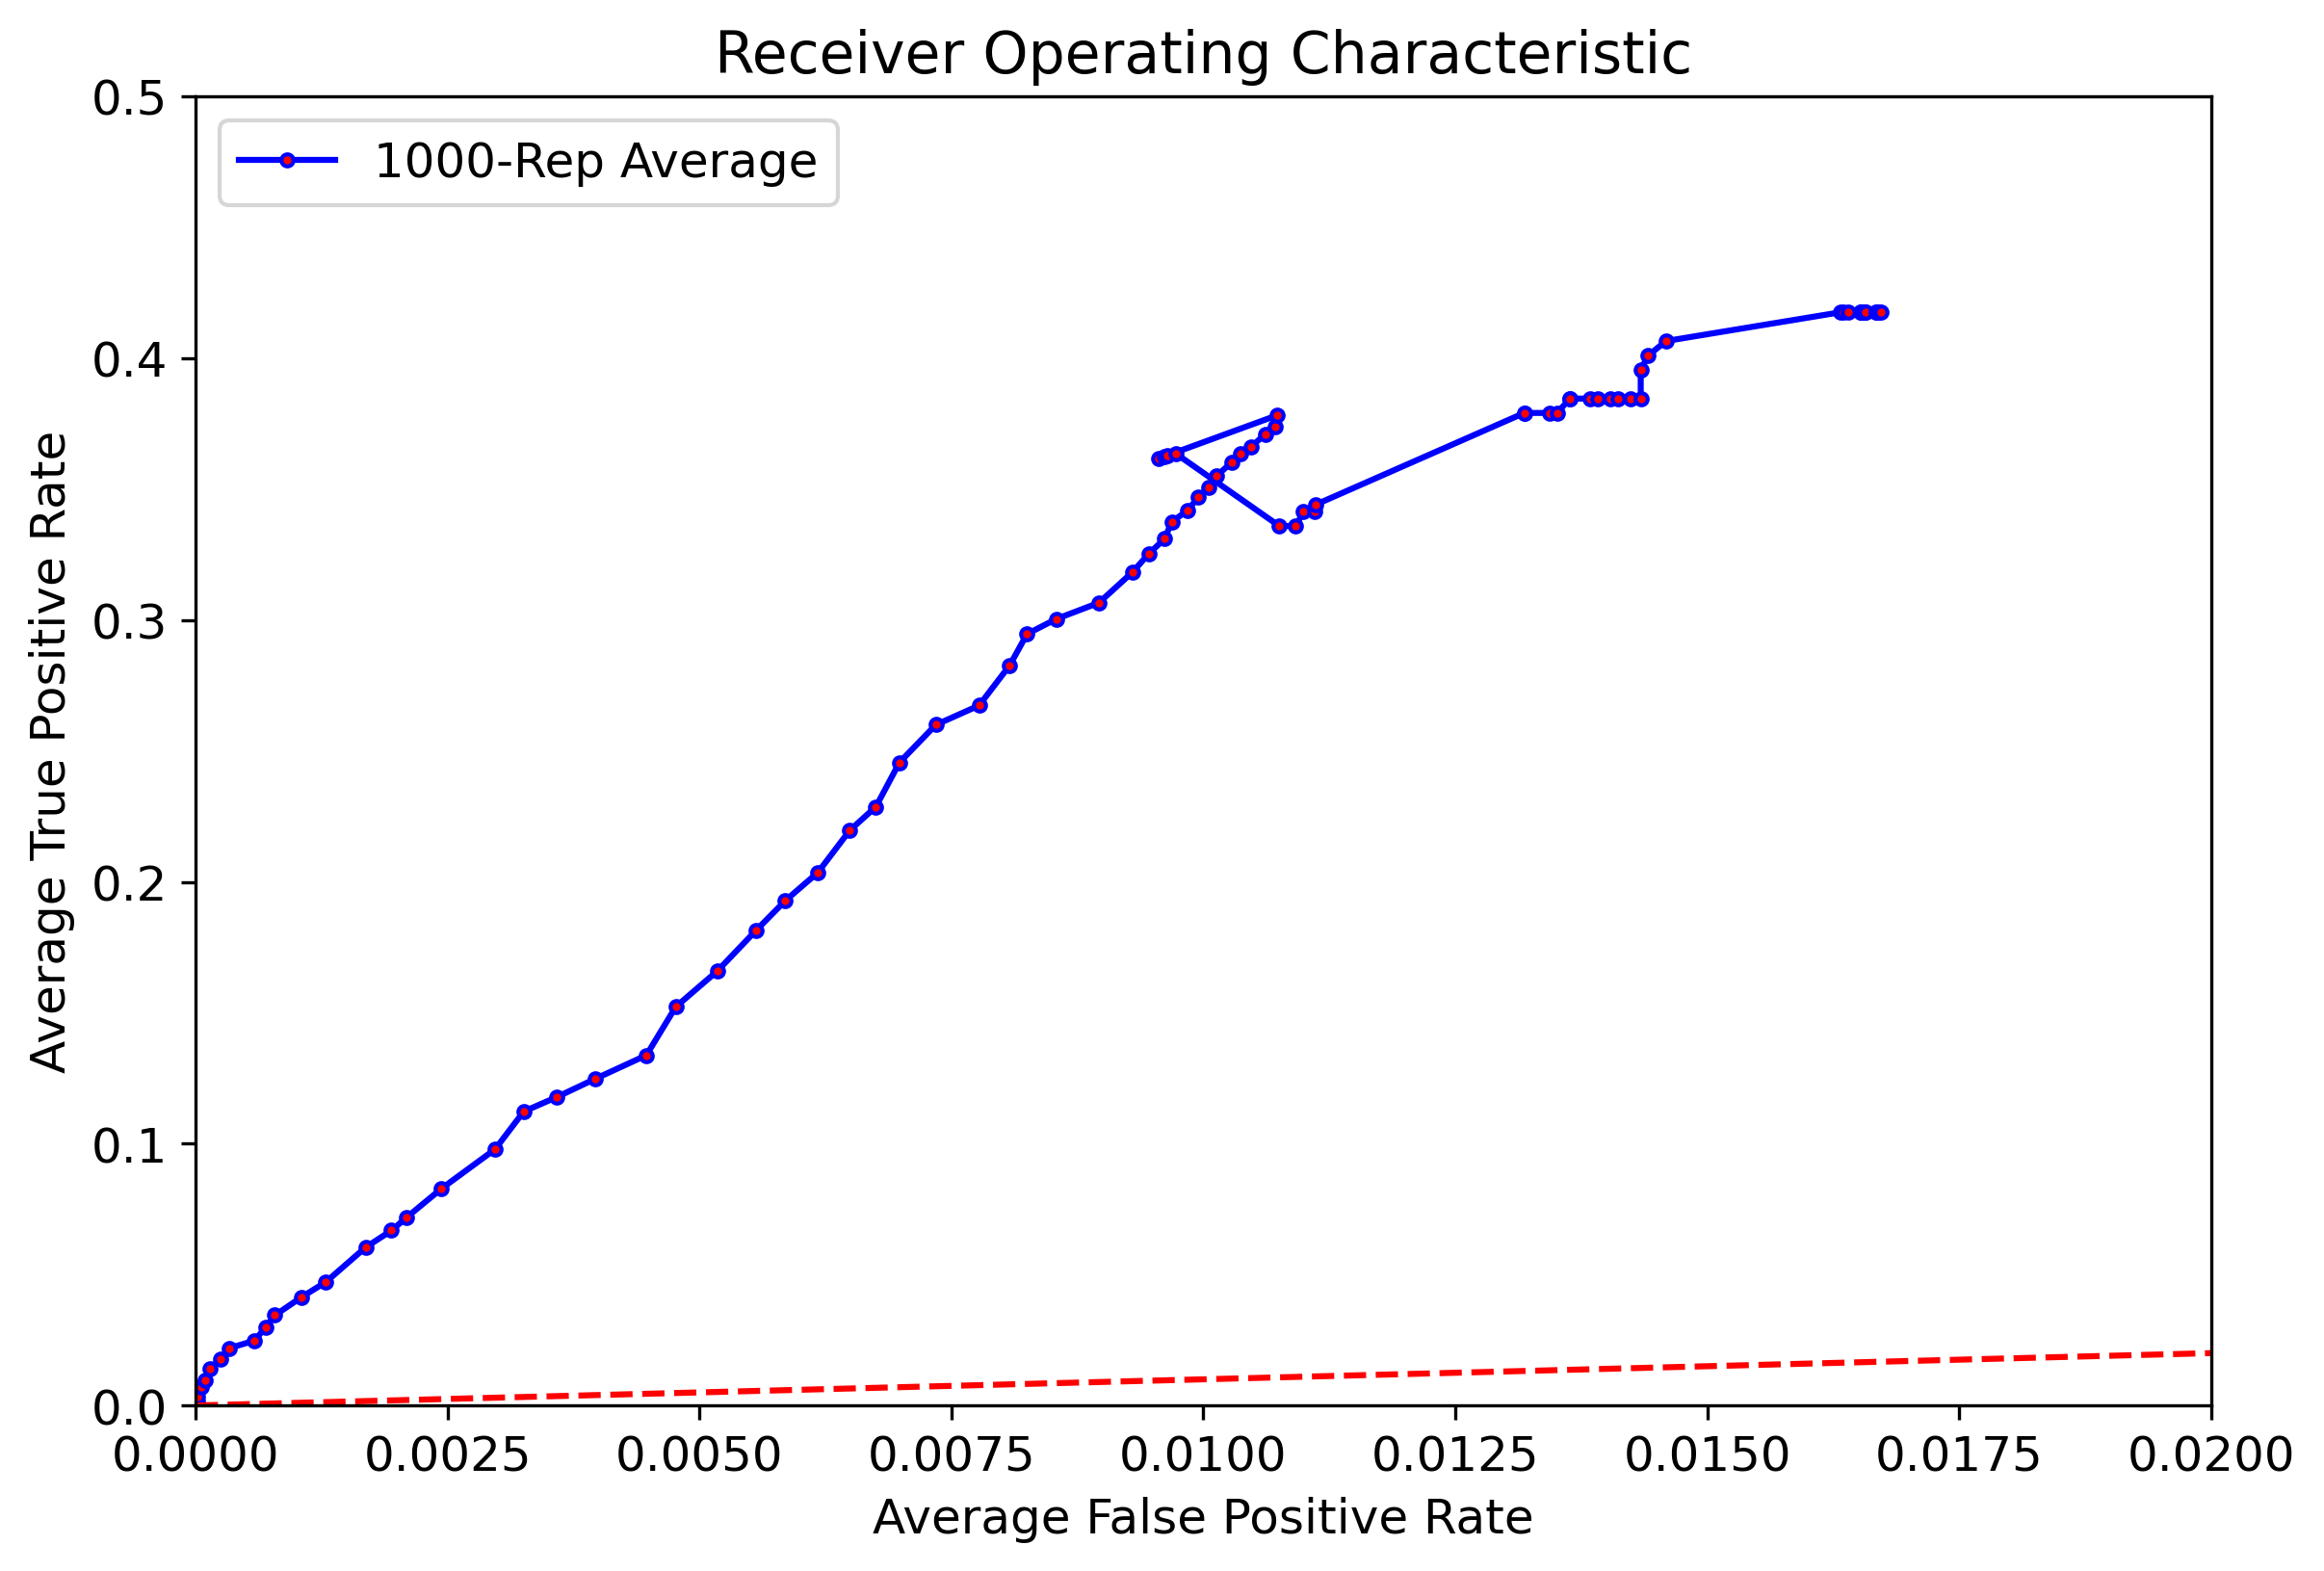

In [14]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(9, 6), dpi=300)

plt.title('Receiver Operating Characteristic')
plt.plot(avg_fpr, avg_tpr, marker='o', markersize='3', markerfacecolor='r', color='b')

# FIX LEGEND NAMES
plt.legend(["1000-Rep Average"], loc="upper left")
plt.plot([0, .5], [0, .5],'r--')
plt.xlim([0, .02])
plt.ylim([0, .5])
plt.ylabel('Average True Positive Rate')
plt.xlabel('Average False Positive Rate')
plt.show()

In [15]:
i = 75
print(str(avg_fpr[i-1]) + '==>' + str(avg_fpr[i]))
print(str(avg_tpr[i-1]) + '==>' + str(avg_tpr[i]))
if avg_fpr[i-1] < avg_fpr[i]:
    print(True)
else:
    print(False)
if avg_tpr[i-1] < avg_tpr[i]:
    print(True)
else:
    print(False)

0.014591390828268623==>0.01632427545331257
0.4065934065934066==>0.4175824175824176
True
True


In [16]:
print(np.nonzero(fpr[0])[0][-1]+1)
print(np.nonzero(fpr[1])[0][-1]+1)
print(np.nonzero(fpr[2])[0][-1]+1)
print(np.nonzero(fpr[3])[0][-1]+1)

60
89
51
55


In [17]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [18]:
#list(avg_tpr/avg_fpr)

/var/folders/yb/0fbdqb990czb79fqpq12c98h0000gp/T/ipykernel_2811/2852981736.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.arange(100), list(avg_tpr/avg_fpr), marker='o', markersize='3', markerfacecolor='r', color='b')


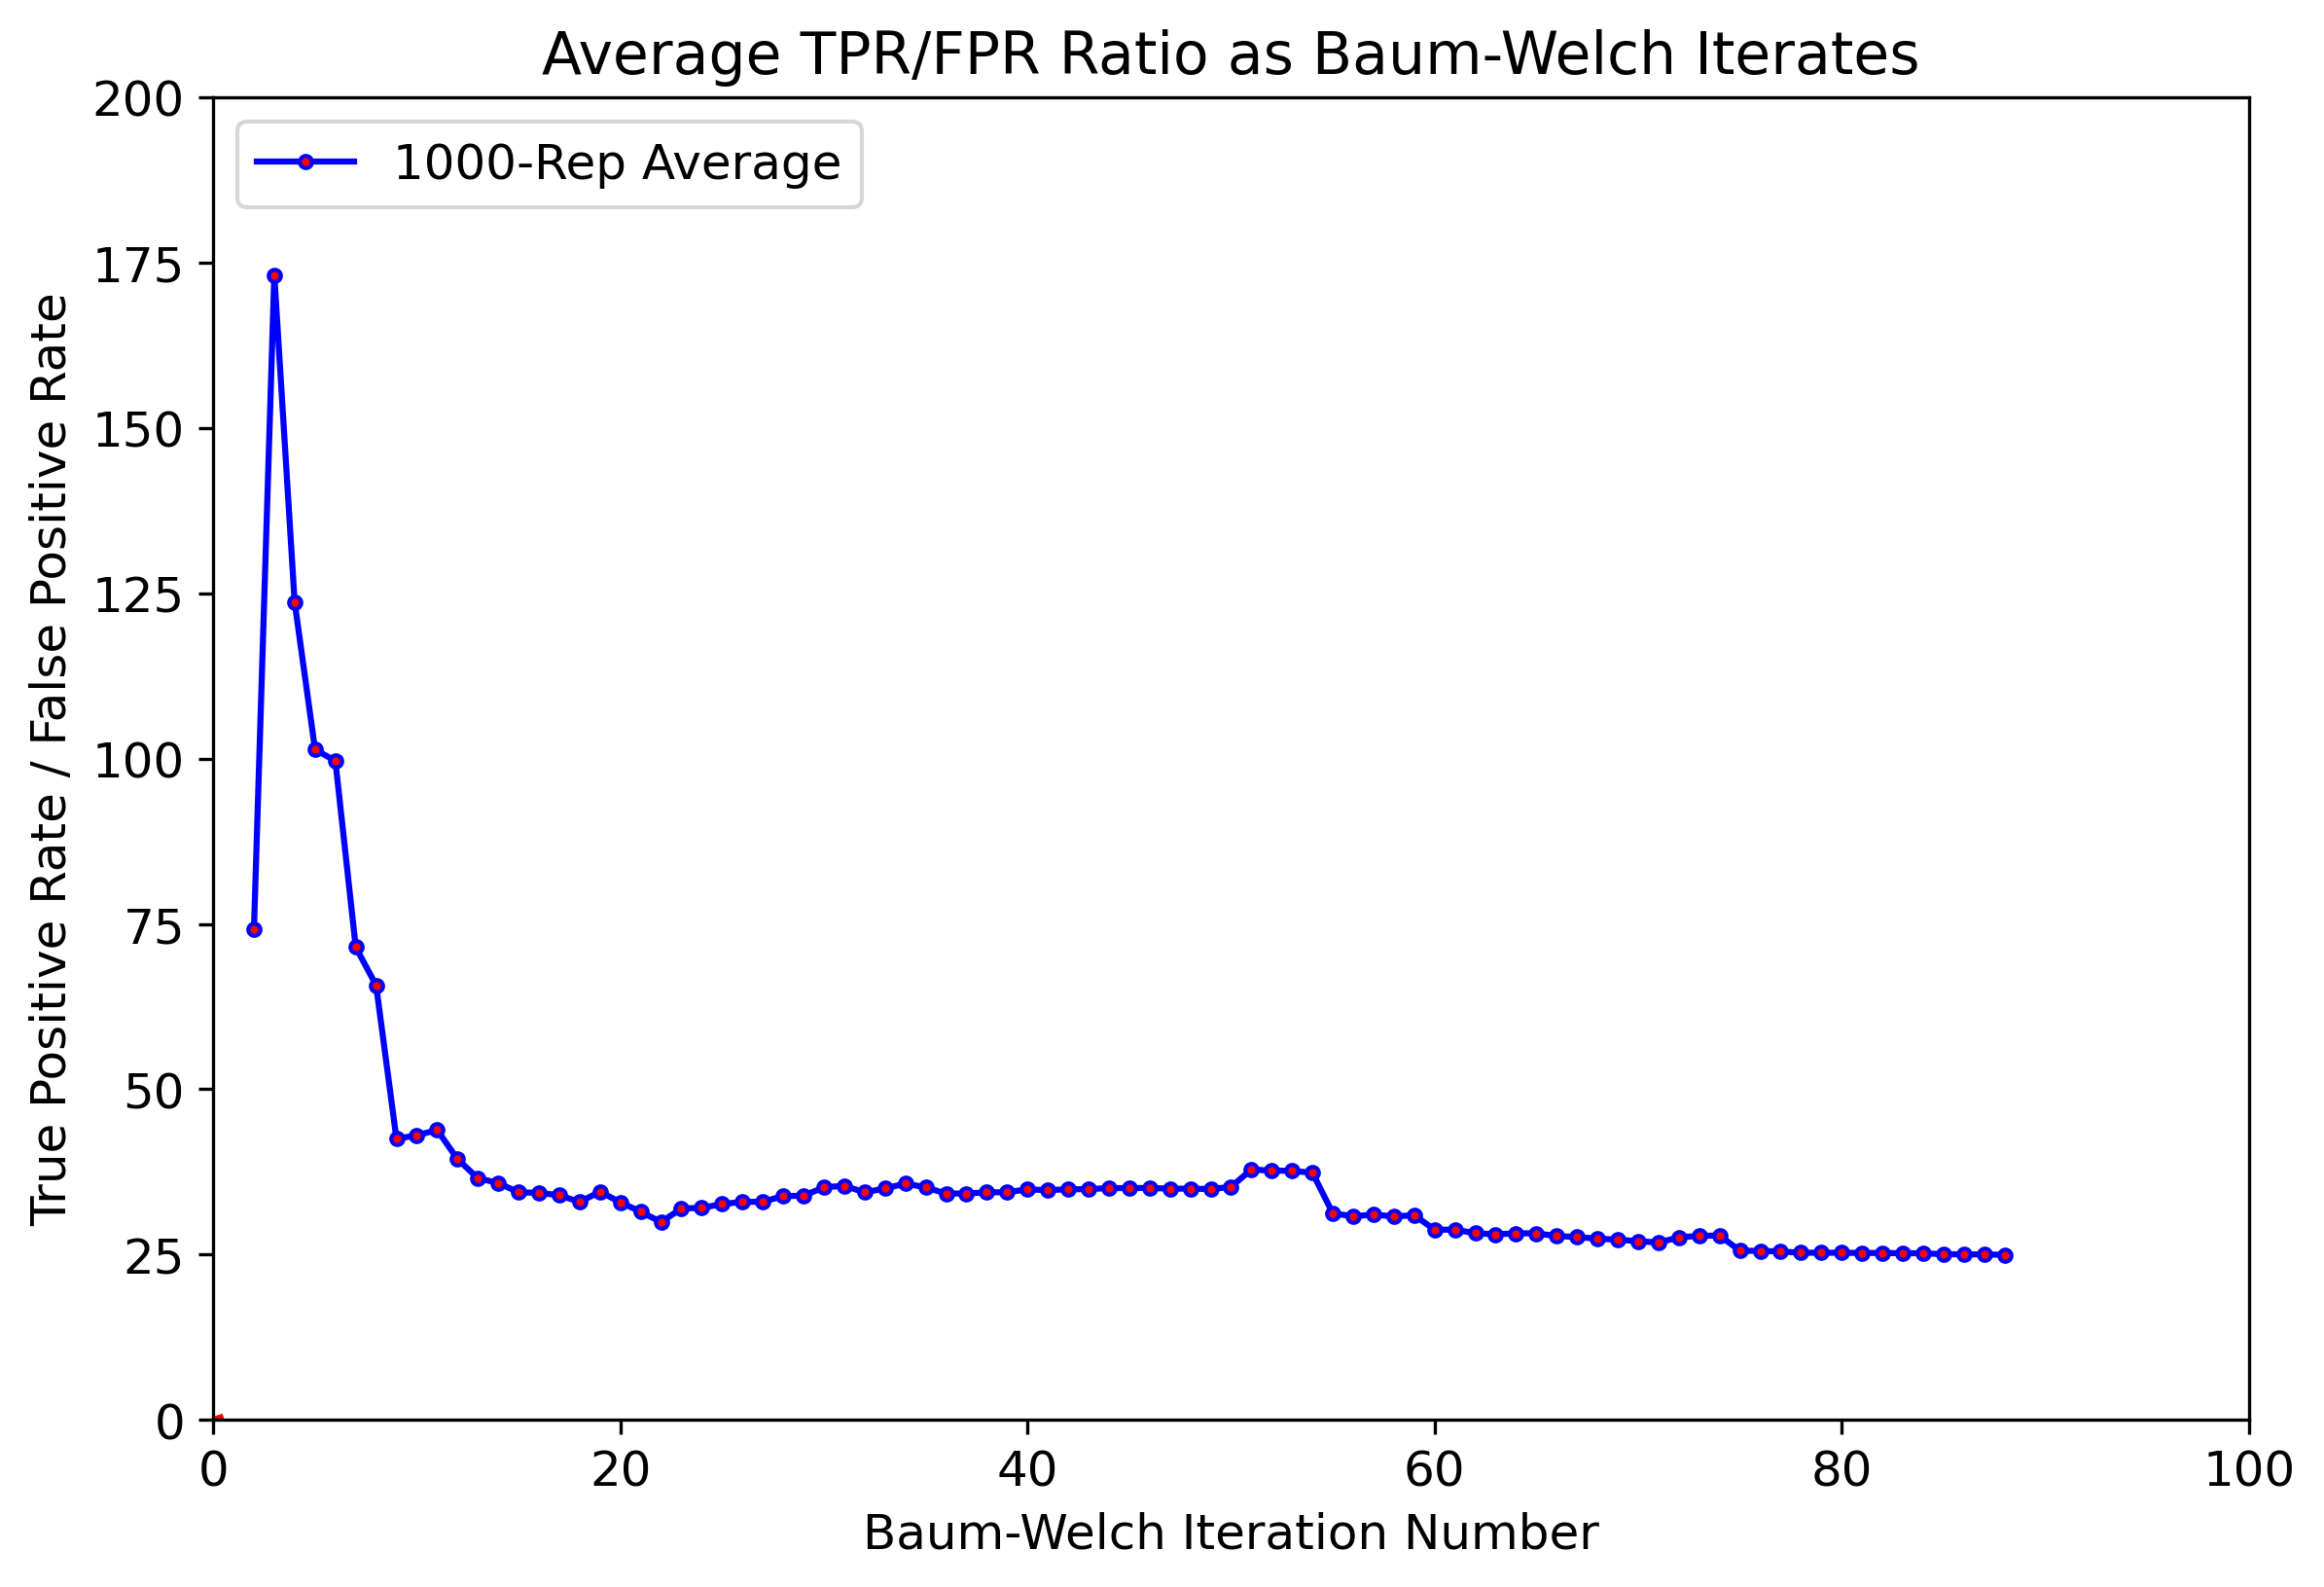

In [19]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(9, 6), dpi=300)

plt.title('Average TPR/FPR Ratio as Baum-Welch Iterates')
plt.plot(np.arange(100), list(avg_tpr/avg_fpr), marker='o', markersize='3', markerfacecolor='r', color='b')

# FIX LEGEND NAMES
plt.legend(["1000-Rep Average"], loc="upper left")
plt.plot([0, .5], [0, .5],'r--')
plt.xlim([0, 100])
plt.ylim([0, 200])
plt.ylabel('True Positive Rate / False Positive Rate')
plt.xlabel('Baum-Welch Iteration Number')
plt.show()